# Logit Lens の可視化をしてみる
Hidden State に加え、Attention層後の中間層の出力を Logit Lens に渡して可視化してみます。

### 準備

In [ ]:
# ライブラリのインポート
from pprint import pprint

import imageio
from PIL import Image
from transformers import AutoTokenizer

from _transformers.model_with_alias import AutoModelForCausalLMWithAliases

# ローカルの関数をインポート
from get_hidden_stete_with_hook import main as get_hidden_state
from logit_lens import (
    LogitLens,
    prepare_data_for_logit_lens_with_mid_layer,
    visualize_logit_lens,
)

on_jupyter = (
    True  # Set False to visualize in GitHub, Set True to visualize in Jupyter Notebook
)

In [2]:
model_name_or_path = "gpt2"
# model_name_or_path = "meta-llama/Llama-3.2-1B"
prompt = "Tokyo is the capital of Japan."

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

model = AutoModelForCausalLMWithAliases.from_pretrained(model_name_or_path)
model.eval()

logit_lens = LogitLens(model)

### Hookを使って隠れ状態を取得する


In [3]:
hidden_states = get_hidden_state(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
)
pprint(hidden_states.keys())

]8;id=622461;file:///Users/238-gs20253502/Documents/codes/hook-hf-tutorial/src/utils/logger.py\logger.py]8;;\:]8;id=447776;file:///Users/238-gs20253502/Documents/codes/hook-hf-tutorial/src/utils/logger.py#78\78]8;;\
2025-07-16 21:53:56,839/WARNING/get_hidden_stete_with_hook/warn_once():78                                          
Assuming mid_layer is the sum of Attention output and input to the layer.                                          

]8;id=581097;file:///Users/238-gs20253502/Documents/codes/hook-hf-tutorial/src/utils/logger.py\logger.py]8;;\:]8;id=278487;file:///Users/238-gs20253502/Documents/codes/hook-hf-tutorial/src/utils/logger.py#78\78]8;;\
2025-07-16 21:53:56,919/WARNING/hook/warn_once():78                                                                
Ignored unexpected keys: {'self_attn_weights'}                                                                     

dict_keys(['hidden_states', 'mid_layer_hidden_states'])


### LogitLensを使ってみる

In [4]:
topk = 5
# topk = None

logit_lens_result = logit_lens.lens(
    hidden_states["hidden_states"], prob=True, topk=topk
)
logit_lens_result_mid_layer = logit_lens.lens(
    hidden_states["mid_layer_hidden_states"], prob=True, topk=topk
)

if topk is None:
    print(
        f"Hidden Logits: {logit_lens_result.shape}\nMid Layer Logits: {logit_lens_result_mid_layer.shape}"
    )
else:
    print(
        f"Hidden Logits: {logit_lens_result.values.shape}\nMid Layer Logits: {logit_lens_result_mid_layer.values.shape}"
    )

Hidden Logits: torch.Size([13, 8, 5])
Mid Layer Logits: torch.Size([12, 8, 5])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


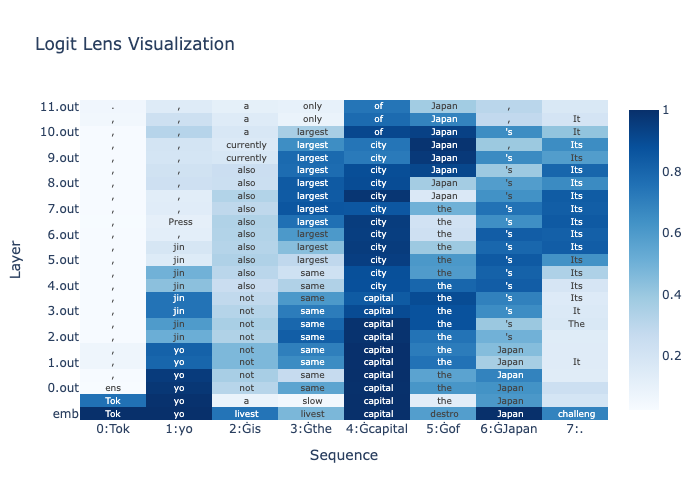

In [5]:
probs, indices, y_labels = prepare_data_for_logit_lens_with_mid_layer(
    logit_lens_prob_topk=logit_lens_result,
    logit_lens_prob_topk_mid_layer=logit_lens_result_mid_layer,
)


fig = visualize_logit_lens(
    probs=probs,
    inputs=[f"{i}:{token}" for i, token in enumerate(tokenizer.tokenize(prompt))],
    decoded=[
        [[tokenizer.decode(k) for k in position] for position in layer]
        for layer in indices
    ],
    y_labels=y_labels,
)
if not on_jupyter:
    fig = Image.fromarray(imageio.v2.imread(fig.to_image(format="png")))

fig